# Prediction of Large-Scale Power Spectrum Multipoles

Start in the appropriate notebook directory.

In [1]:
# %cd /mnt/lustre/mikewang/projects/HorizonGRound/notebooks/

Import the appropriate packages.

In [2]:
import glob
import os
import re
from collections import defaultdict

import corner
import h5py
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Math
from astropy.constants import c
from astropy.cosmology import Planck15
from matplotlib.ticker import AutoMinorLocator
from nbodykit.cosmology import LinearPower, Planck15 as Planck_15


from conf import PATHOUT
from horizonground.clustering_modification import (
    non_gaussianity_correction_factor,
    relativistic_correction_factor,
    standard_kaiser_factor,
)

os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

model = np.random.choice(["PLE_model"])  # "PLE_model", "hybrid_model"
threshold = "-25.0"  # "-22.0", "-25.0"

print("Selected: {}, magnitude limit {}".format(model, threshold))

publication_dir = PATHOUT/"publication"/model

Selected: PLE_model, magnitude limit -25.0


Set fiducial values.

In [3]:
FIDUCIAL_REDSHIFT = 2.
FIDUCIAL_LINEAR_BIAS = 1.2 / Planck_15.scale_independent_growth_factor(FIDUCIAL_REDSHIFT)
FIDUCIAL_NON_GAUSSNIANTY = 1.
FIDUCIAL_WAVENUMBERS = np.logspace(-4., -1., num=60+1)

In [4]:
display(Math(r"\text{{Linear tracer bias }} b_1 = {:.2f}.".format(FIDUCIAL_LINEAR_BIAS)))

<IPython.core.display.Math object>

## Relativistic correction quantiles

In [5]:
chain_files = glob.glob("/".join([
    str(publication_dir), "dense_points", "correction",  # "eBOSS_binning",  #
    "relcrct_z{:.2f}_m{}*".format(FIDUCIAL_REDSHIFT, threshold)
]))

print("/".join([
    str(publication_dir), "dense_points", "correction",  # "eBOSS_binning",  #
    "relcrct_z{:.2f}_m{}*".format(FIDUCIAL_REDSHIFT, threshold)
]))

/home/mikew/Documents/HorizonGRound/storage/output/publication/PLE_model/dense_points/correction/relcrct_z2.00_m-25.0*


In [6]:
quantile_levels = [0.022750, 0.158655, 0.5, 0.841345, 0.977250]

In [7]:
gz_quantiles = defaultdict(list)
for chain_file in chain_files:
    with h5py.File(chain_file, 'r') as chain_data:
        distilled = chain_data['distill/chain'][()]
        gz_square_q = corner.quantile(np.square(distilled), q=quantile_levels)
    for sigma_level_idx, sigma_level in enumerate([-2, -1, 0, 1, 2]):
        gz_quantiles[sigma_level].append(np.sqrt(gz_square_q[sigma_level_idx]))

In [8]:
inv_H = c.to('km/s') * Planck15.h / Planck15.H(FIDUCIAL_REDSHIFT)
chi = Planck15.h * Planck15.comoving_distance(FIDUCIAL_REDSHIFT)

display(Math(
    r"\text{{Estimate of relativistic correction function }} \mathcal{{H}}\chi g(z={}) = {:.2f}."
    .format(FIDUCIAL_REDSHIFT, gz_quantiles[0][0] * chi.value)
))
display(Math(
    r"\text{{Estimate of relativistic correction function }} g(z={}) = {:.2f}."
    .format(FIDUCIAL_REDSHIFT, gz_quantiles[0][0] * inv_H.value)
))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Modified clustering multipoles

In [9]:
matter_power_spectrum = LinearPower(Planck15, FIDUCIAL_REDSHIFT)(FIDUCIAL_WAVENUMBERS)

In [10]:
RSD_multipoles = {
    ell: standard_kaiser_factor(
        ell, FIDUCIAL_LINEAR_BIAS, FIDUCIAL_REDSHIFT, cosmo=Planck_15
    ) * matter_power_spectrum
    for ell in [0, 2]
}

In [11]:
PNG_multipoles = {
    ell: RSD_multipoles[ell] + non_gaussianity_correction_factor(
        FIDUCIAL_WAVENUMBERS, ell, 
        FIDUCIAL_NON_GAUSSNIANTY, FIDUCIAL_LINEAR_BIAS, FIDUCIAL_REDSHIFT,
        cosmo=Planck_15, tracer_p=1.6
    ) * matter_power_spectrum
    for ell in [0, 2]
}

PNG_multipoles_upper = {
    ell: RSD_multipoles[ell] + non_gaussianity_correction_factor(
        FIDUCIAL_WAVENUMBERS, ell, 
        FIDUCIAL_NON_GAUSSNIANTY + 1., FIDUCIAL_LINEAR_BIAS, FIDUCIAL_REDSHIFT,
        cosmo=Planck_15, tracer_p=1.6
    ) * matter_power_spectrum
    for ell in [0, 2]
}

PNG_multipoles_lower = {
    ell: RSD_multipoles[ell] + non_gaussianity_correction_factor(
        FIDUCIAL_WAVENUMBERS, ell, 
        FIDUCIAL_NON_GAUSSNIANTY - 1., FIDUCIAL_LINEAR_BIAS, FIDUCIAL_REDSHIFT,
        cosmo=Planck_15, tracer_p=1.6
    ) * matter_power_spectrum
    for ell in [0, 2]
}

In [12]:
GR_multipoles = {
    ell: RSD_multipoles[ell] + relativistic_correction_factor(
        FIDUCIAL_WAVENUMBERS, ell, FIDUCIAL_REDSHIFT,
        correction_value=np.asarray(gz_quantiles[0]),
        cosmo=Planck_15
    ) * matter_power_spectrum
    for ell in [0, 2]
}

GR_multipoles_lower = {
    ell: RSD_multipoles[ell] + relativistic_correction_factor(
        FIDUCIAL_WAVENUMBERS, ell, FIDUCIAL_REDSHIFT,
        correction_value=np.asarray(gz_quantiles[-2]),
        cosmo=Planck_15
    ) * matter_power_spectrum
    for ell in [0, 2]
}

GR_multipoles_upper = {
    ell: RSD_multipoles[ell] + relativistic_correction_factor(
        FIDUCIAL_WAVENUMBERS, ell, FIDUCIAL_REDSHIFT,
        correction_value=np.asarray(gz_quantiles[2]),
        cosmo=Planck_15
    ) * matter_power_spectrum
    for ell in [0, 2]
}

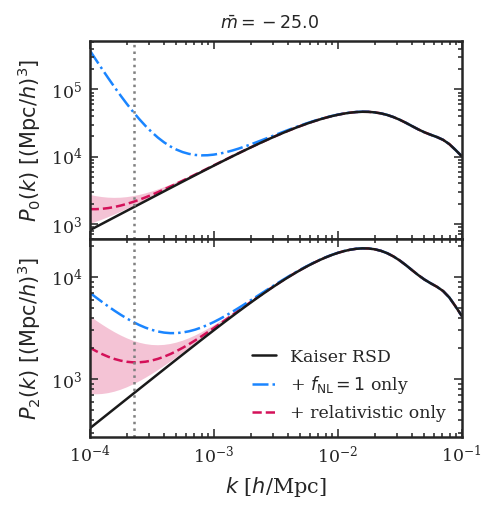

In [13]:
ALPHA = 0.25

monopole_divisor = 1.  # 1. / FIDUCIAL_WAVENUMBERS  # RSD_multipoles[0]
quadrupole_divisor = 1.  # 1. / FIDUCIAL_WAVENUMBERS  # RSD_multipoles[2]
scaling = 'log'  # 'log' # 'linear'

fig = plt.figure("clustering multipoles", figsize=(3.2, 3.5), dpi=150)

horizon_scale = Planck15.scale_factor(FIDUCIAL_REDSHIFT) * Planck15.H(FIDUCIAL_REDSHIFT) / c.to('km/s')

monopole = plt.subplot2grid((2, 1), (0, 0))

monopole.loglog(
    FIDUCIAL_WAVENUMBERS, RSD_multipoles[0] / monopole_divisor,
    c='k', zorder=0
)
monopole.loglog(
    FIDUCIAL_WAVENUMBERS, PNG_multipoles[0] / monopole_divisor,
    ls='-.', c='#1A85FF', zorder=-1
)
monopole.loglog(
    FIDUCIAL_WAVENUMBERS, GR_multipoles[0] / monopole_divisor,
    ls='--', c='#D41159', zorder=-2
)

monopole.fill_between(
    FIDUCIAL_WAVENUMBERS,
    GR_multipoles_lower[0] / monopole_divisor,
    GR_multipoles_upper[0] / monopole_divisor,
    facecolor='#D41159', edgecolor='None', alpha=ALPHA, zorder=-3
)

monopole.axvline(x=horizon_scale.value, ls=':', c='0.5')

monopole.tick_params(axis='x', which='both', labelbottom=False)
monopole.set_xlim(min(FIDUCIAL_WAVENUMBERS), max(FIDUCIAL_WAVENUMBERS))
monopole.set_yscale(scaling)
monopole.set_ylabel(r"$P_0(k)\ [(\mathrm{Mpc}/h)^3]$")

quadrupole = plt.subplot2grid((2, 1), (1, 0), sharex=monopole)

quadrupole.loglog(
    FIDUCIAL_WAVENUMBERS, RSD_multipoles[2] / quadrupole_divisor, 
    c='k', zorder=0, label="Kaiser RSD"
)
quadrupole.loglog(
    FIDUCIAL_WAVENUMBERS, PNG_multipoles[2] / quadrupole_divisor,
    ls='-.', c='#1A85FF', zorder=-1, label=r"+ $f_\mathrm{NL} = 1$ only"
)
quadrupole.loglog(
    FIDUCIAL_WAVENUMBERS, GR_multipoles[2] / quadrupole_divisor,
    ls='--', c='#D41159', zorder=-2, label="+ relativistic only"
)
quadrupole.fill_between(
    FIDUCIAL_WAVENUMBERS,
    GR_multipoles_lower[2] / quadrupole_divisor, 
    GR_multipoles_upper[2] / quadrupole_divisor,
    facecolor='#D41159', edgecolor='None', alpha=ALPHA, zorder=-3
)

quadrupole.axvline(x=horizon_scale.value, ls=':', c='0.5')

quadrupole.legend(handlelength=1.4)
quadrupole.set_yscale(scaling)
quadrupole.set_xlabel(r"$k$ [$h$/Mpc]")
quadrupole.set_ylabel(r"$P_2(k)\ [(\mathrm{Mpc}/h)^3]$")

fig.suptitle(r"$\bar{{m}} = {}$".format(threshold), fontsize='small', y=0.93)
fig.savefig(
    publication_dir/"gallery"/"clustering_multipoles_z{}_m{}.pdf"
    .format(FIDUCIAL_REDSHIFT, threshold)
)